# Análise da FRF por tratamento estatístico

Neste notebook avaliamos o uso do método de Welch para estimativas da FRF. Vamos considerar situações em que teremos

- Ruído contaminante apenas na saída do sistema: $x_m(t) = x(t)$ e $y_m(t) = y(t)+n_y(t)$ - situação comum
- Ruído contaminante apenas na entrada do sistema: $x_m(t) = x(t) + n_x(t)$ e $y_m(t) = y(t)$ - situação rara
- Ruído contaminante apenas na entrada e saída do sistema: $x_m(t) = x(t) + n_x(t)$ e $y_m(t) = y(t)+n_y(t)$

In [1]:
# importar as bibliotecas necessárias
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 14})
from scipy import signal
import IPython.display as ipd # to play signals
import sounddevice as sd
import soundfile as sf

# SLIT analisado

Vamos criar um SLIT, que receberá um sinal de entrada $x(t)$ e gerará um sinal de saída $y(t)$. O SLIT será representado por uma função chamada de ***black_box***. Aos sinais de entrada e/ou saída, podemos adicionar um ruído aleatório Gaussiano. Dessa, forma teremos uma medição do tipo:

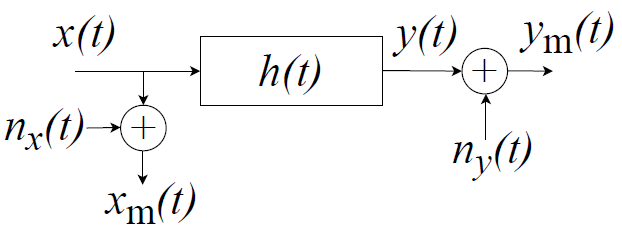

In [2]:
def black_box(xt, Fs = 44100, snr = 80, noise_at = 'both'):
    """ SLIT black box
    
    Author: Eric Brandão - 11/2020
    This function emulates a SLIT measurement. System parameters
    are used to generate a reference h(t) and FRF. We, then, compute
    noiseless versions of x(t) and y(t) using the FFT. We add noise
    to the signals. The SNR is calculated based on x(t). Finally,
    we apply a low pass filter to emulate an anti-aliasing filter.
    
    Parameters:
    -------------
    xt : numpy 1darray
        Input signal
    Fs : int
        Sampling frequency
    snr : float
        Signal to noise ratio relative to x(t)
    noise_at : str
        Choose to which signal you apply noise. If 'out', 
        noise is applied only to y(t), if 'in', noise is applied
        only to x(t). else, noise is applied to both signals
    
    Returns:
    ------------
    th : numpy 1darray
        time vector of reference impulse response
    h : numpy 1darray
        reference impulse response
    fh : numpy 1darray
        frequency vector of reference FRF
    H : numpy 1darray
        reference FRF (Frequency Response Function)
    ty : numpy 1darray
        time vector of the output signal
    yt : numpy 1darray
        output signal  with added noise
    tx : numpy 1darray
        time vector of the input signal
    xt : numpy 1darray
        input signal with added noise
    """
    # System parameters
    A = [2.3, 1.5]
    f_res = [110, 415]
    w_res = 2*np.pi*np.array(f_res)
    zeta = [0.02, 0.01]
    wd = np.sqrt(1-np.array(zeta)**2)*np.array(w_res)
    # Reference impulse response
    th = np.arange(0, 1, 1/Fs)
    h=(A[0]/wd[0])*np.exp(-zeta[0]*w_res[0]*th)*np.sin(wd[0]*th) +\
        (A[1]/wd[1])*np.exp(-zeta[1]*w_res[1]*th)*np.sin(wd[1]*th)
    # reference frequency response
    fh = np.linspace(0, (len(h)-1)*Fs/len(h), len(h))
    H = (A[0]/(w_res[0]**2 - (2*np.pi*fh)**2 + 1j*2*zeta[0]*w_res[0]*(2*np.pi*fh)) +\
        A[1]/(w_res[1]**2 - (2*np.pi*fh)**2 + 1j*2*zeta[1]*w_res[1]*(2*np.pi*fh)))*Fs
    # Compute SLIT noiseless output
    N = len(xt) + len(h) - 1
    Xjw = np.fft.fft(xt, N)
    Hjw = np.fft.fft(h, N)
    Yjw = Xjw * Hjw
    yt = np.real(np.fft.ifft(Yjw))
    ty = np.linspace(0, (N-1)/Fs, N)
    # add noise to signals
    x_var = (np.std(xt))**2 # input RMS**2, assuming zero mean
    noise_var_dB = 10*np.log10(x_var) - snr
    noise_var = 10**(noise_var_dB/10)
    if noise_at == 'out':
        yt = yt + np.random.normal(loc=0, scale = np.sqrt(noise_var), size = len(yt))
    elif noise_at == 'in':
        xt = xt + np.random.normal(loc=0, scale = np.sqrt(noise_var), size = len(xt))
    else:
        yt = yt + np.random.normal(loc=0, scale = np.sqrt(noise_var), size = len(yt))
        xt = xt + np.random.normal(loc=0, scale = np.sqrt(noise_var), size = len(xt))
    print("xt var in dB {:.2f}".format(10*np.log10(x_var)))
    print("noise_var in dB {:.2f}".format(10*np.log10(noise_var)))
    # Complete xt with zeros
    xt = np.concatenate([xt, np.zeros(N-len(xt))])
    tx = np.linspace(0, (len(xt)-1)/Fs, len(xt))
    # Anti aliasing
    sos = signal.butter(10, 0.8*Fs/2, 'low', fs=Fs, output='sos')
    xt = signal.sosfilt(sos, xt)
    yt = signal.sosfilt(sos, yt)
    
    return th, h, fh, H, ty, yt, tx, xt
    

# Criar uma versão de $x(t)$ sem anti-aliasing e ruído adicional

Este sinal, $x(t)$, é o sinal que você entregaria ao seu SLIT sem qualquer contaminação.

In [3]:
fs = 10000
Tp = 10
time = np.arange(0, Tp, 1/fs)
# sinal aleatório completo - pré ruído e filtragem
xt = np.random.normal(loc = 0, scale = 1, size = len(time))

# Passar $x(t)$ pelo SLIT

Neste passo, vamos passar o sinal ao SLIT. O SLIT emula um sistema com duas ressonâncias e uma anti-ressonância. A função também emula a adição de ruído e o filtro anti-aliasing presente no seu conversor AD.

xt var in dB -2.18
noise_var in dB -52.18


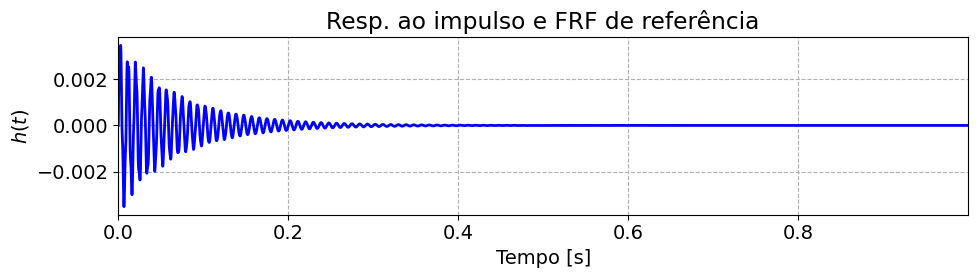

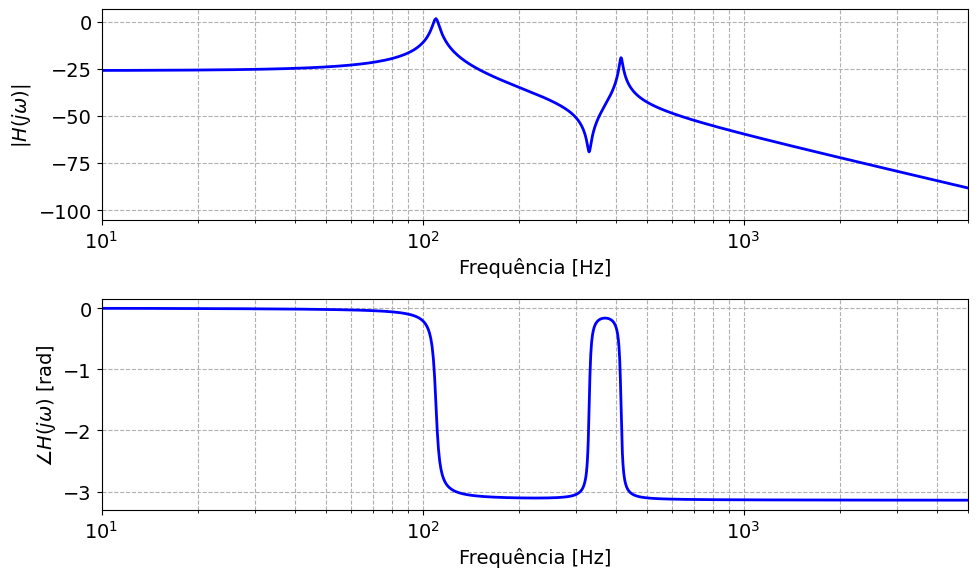

In [28]:
th, h, fh, H, ty, yt, tx, xt = black_box(xt, Fs = fs, 
     snr = 50, noise_at = 'both')

# plot signal
plt.figure(figsize = (10, 3))
plt.plot(th, h, linewidth = 2, color = 'b')
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$h(t)$')
plt.xlim((0, th[-1]))
#plt.ylim((-4, 4))
plt.xlabel('Tempo [s]')
plt.title('Resp. ao impulso e FRF de referência')
plt.tight_layout()

plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.semilogx(fh, 20*np.log10(np.abs(H)), linewidth = 2, color = 'b')
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$|H(j \omega)|$')
plt.xlim((10, fs/2))
#plt.ylim((-4, 4))
plt.xlabel('Frequência [Hz]')

plt.subplot(2,1,2)
plt.semilogx(fh, np.angle(H), linewidth = 2, color = 'b')
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$\angle H(j \omega)$ [rad]')
plt.xlim((10, fs/2))
#plt.ylim((-4, 4))
plt.xlabel('Frequência [Hz]')
plt.tight_layout()

# Inspecione $x(t)$ e $y(t)$ - talvez haja algum insight

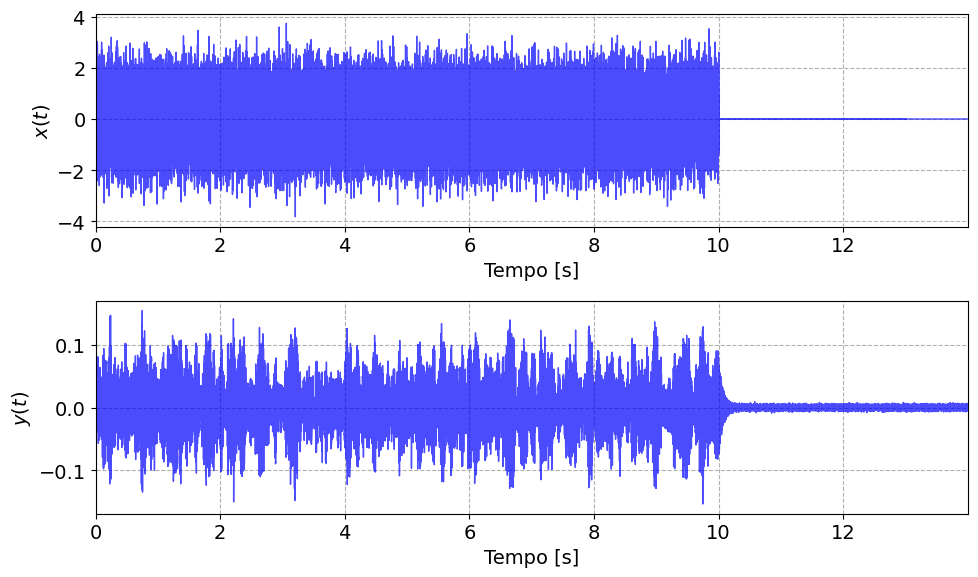

In [29]:
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.plot(tx, xt, linewidth = 1, color = 'b', alpha = 0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$x(t)$')
plt.xlim((0, ty[-1]))
plt.xlabel('Tempo [s]')

plt.subplot(2,1,2)
plt.plot(ty, yt, linewidth = 1, color = 'b', alpha = 0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$y(t)$')
plt.xlim((0, ty[-1]))
plt.xlabel('Tempo [s]')
plt.tight_layout()

# Podemos ouvir os sinais

In [6]:
ipd.Audio(xt, rate=fs) # load a NumPy array

In [7]:
ipd.Audio(yt, rate=fs) # load a NumPy array

# Computar a FRF via $S_{xy}$ e $S_{xx}$

Vamos usar o estimador $H_1$, dado por

\begin{equation}
H_1(\mathrm{j}\omega) = \frac{S_{xy}(\mathrm{j}\omega)}{S_{xx}(\mathrm{j}\omega)}
\tag{1}
\end{equation}

# Vamos computar todos os auto-espectros e espectros cruzados

- $S_{xx}(\mathrm{j}\omega)$
- $S_{yy}(\mathrm{j}\omega)$
- $S_{xy}(\mathrm{j}\omega)$
- $S_{yx}(\mathrm{j}\omega)$

In [30]:
# Parâmetros da FRF - válidos para todas as análises subsequentes
win_size = 2048
win = signal.windows.hann(win_size)
noverlap = win_size/2
nfft = win_size*2

# Vamos computar os auto-espectros e espectros cruzados
_, Sxx = signal.csd(xt, xt, fs, window = win, noverlap = noverlap, nfft = nfft, scaling = 'spectrum')
_, Syy = signal.csd(yt, yt, fs, window = win, noverlap = noverlap, nfft = nfft, scaling = 'spectrum')
freq, Sxy = signal.csd(xt, yt, fs, window = win, noverlap = noverlap, nfft = nfft, scaling = 'spectrum')
_, Syx = signal.csd(yt, xt, fs, window = win, noverlap = noverlap, nfft = nfft, scaling = 'spectrum')

# Escrever a resolução do espectro
print("O tamanho da janela é de {:.2f} [s]".format(win_size/fs))
print("A resolução do espectro estimado é {:.2f} [Hz]".format(freq[2]-freq[1]))

O tamanho da janela é de 0.20 [s]
A resolução do espectro estimado é 2.44 [Hz]


# Computar a FRF via $S_{xy}$ e $S_{xx}$

Vamos usar o estimador $H_1$, dado por

\begin{equation}
H_1(\mathrm{j}\omega) = \frac{S_{xy}(\mathrm{j}\omega)}{S_{xx}(\mathrm{j}\omega)}
\tag{1}
\end{equation}

Note as relações de equivalência

\begin{equation}
H_1(\mathrm{j}\omega) = \frac{S_{xy}(\mathrm{j}\omega)}{S_{xx}(\mathrm{j}\omega)} \equiv \frac{X^{*}(\mathrm{j}\omega)Y(\mathrm{j}\omega)}{X^{*}(\mathrm{j}\omega)X(\mathrm{j}\omega)} \equiv \frac{Y(\mathrm{j}\omega)}{X(\mathrm{j}\omega)}
\end{equation}

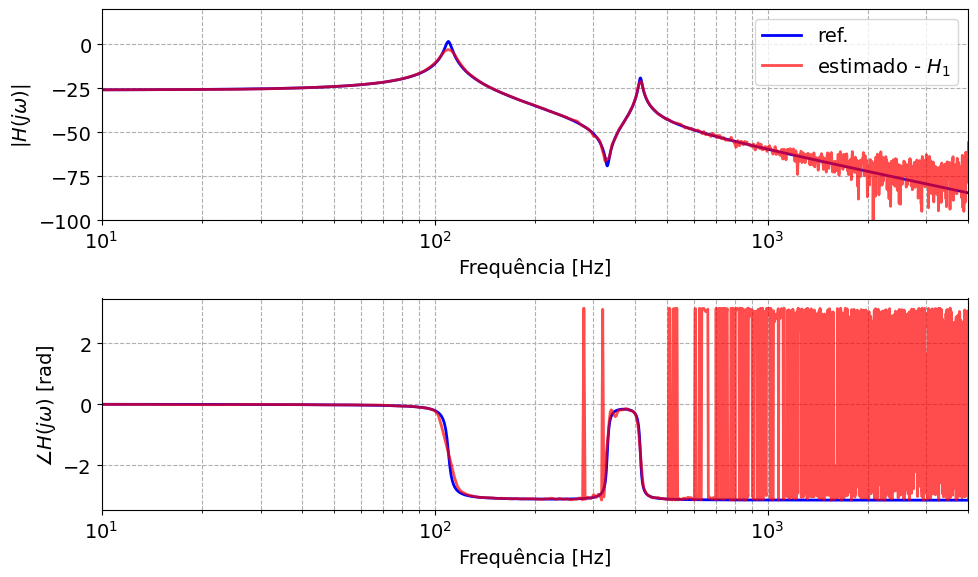

In [31]:
# Estimador H1
H1 = Sxy/Sxx

# Plot
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.semilogx(fh, 20*np.log10(np.abs(H)), linewidth = 2, color = 'b', label = 'ref.')
plt.semilogx(freq, 20*np.log10(np.abs(H1)), linewidth = 2, color = 'r', alpha=0.7, label = r'estimado - $H_1$')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$|H(j \omega)|$')
plt.xlim((10, 0.8*fs/2))
plt.ylim((-100, 20))
plt.xlabel('Frequência [Hz]')

plt.subplot(2,1,2)
plt.semilogx(fh, np.angle(H), linewidth = 2, color = 'b')
plt.semilogx(freq, np.angle(H1), linewidth = 2, color = 'r', alpha=0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$\angle H(j \omega)$ [rad]')
plt.xlim((10, 0.8*fs/2))
#plt.ylim((-4, 4))
plt.xlabel('Frequência [Hz]')
plt.tight_layout()

# Computar a coerência

A função de coerência nos dá uma ideia da qualidade da nossa medição. É uma grandeza variando de $0.0$ a $1.0$, em que $1.0$ representa uma relação perfeitamente linear entre entrada e saída. Valores baixos de coerência estão associados à:

- presença de ruído,
- não linearidades, e
- pequenos erros na estimativa dos espctros.

A coerência é dada por

\begin{equation}
\gamma^{2}(\mathrm{j}\omega) = \frac{|S_{xy}(\mathrm{j}\omega)|^2}{S_{xx}(\mathrm{j}\omega) S_{yy}(\mathrm{j}\omega)}
\tag{2}
\end{equation}

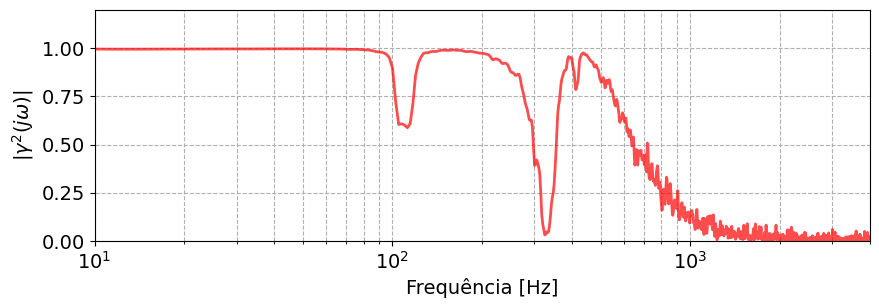

In [32]:
gamma2 =((np.abs(Sxy))**2)/(Sxx * Syy)

# Plot
plt.figure(figsize = (10, 3))
plt.semilogx(freq, gamma2, linewidth = 2, color = 'r', alpha=0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$|\gamma^{2}(j \omega)|$')
plt.xlim((10, 0.8*fs/2))
plt.ylim((0, 1.2))
plt.xlabel('Frequência [Hz]');

# Computar a FRF via $S_{yy}$ e $S_{yx}$

Vamos usar o estimador $H_2$, dado por

\begin{equation}
H_2(\mathrm{j}\omega) = \frac{S_{yy}(\mathrm{j}\omega)}{S_{yx}(\mathrm{j}\omega)}
\tag{3}
\end{equation}

Note as relações de equivalência

\begin{equation}
H_2(\mathrm{j}\omega) = \frac{S_{yy}(\mathrm{j}\omega)}{S_{yx}(\mathrm{j}\omega)} \equiv \frac{Y^{*}(\mathrm{j}\omega)Y(\mathrm{j}\omega)}{Y^{*}(\mathrm{j}\omega)X(\mathrm{j}\omega)} \equiv \frac{Y(\mathrm{j}\omega)}{X(\mathrm{j}\omega)}
\end{equation}

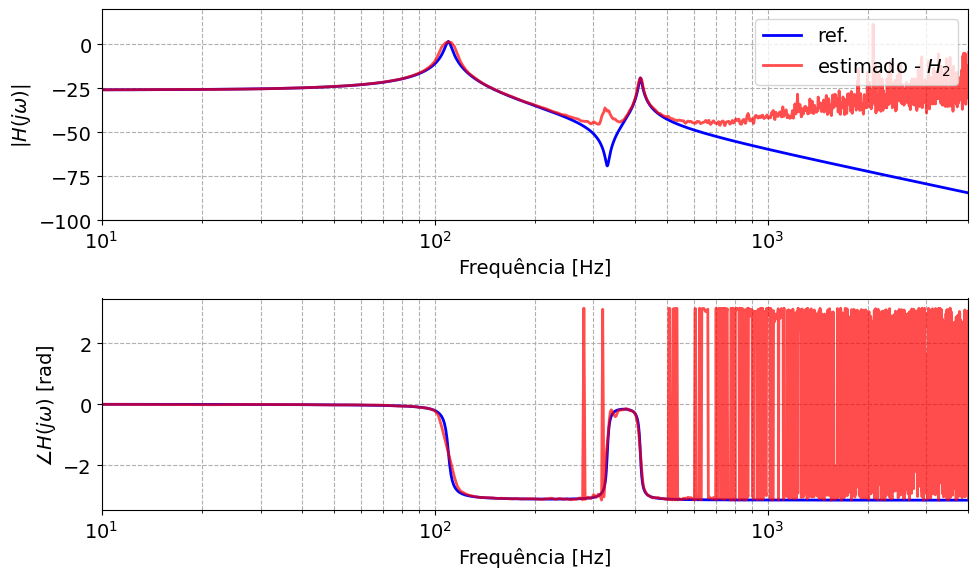

In [33]:
# Estimador H2
H2 = Syy/Syx

# Plot
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.semilogx(fh, 20*np.log10(np.abs(H)), linewidth = 2, color = 'b', label = 'ref.')
plt.semilogx(freq, 20*np.log10(np.abs(H2)), linewidth = 2, color = 'r', alpha=0.7, label = r'estimado - $H_2$')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$|H(j \omega)|$')
plt.xlim((10, 0.8*fs/2))
plt.ylim((-100, 20))
plt.xlabel('Frequência [Hz]')

plt.subplot(2,1,2)
plt.semilogx(fh, np.angle(H), linewidth = 2, color = 'b')
plt.semilogx(freq, np.angle(H2), linewidth = 2, color = 'r', alpha=0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$\angle H(j \omega)$ [rad]')
plt.xlim((10, 0.8*fs/2))
#plt.ylim((-4, 4))
plt.xlabel('Frequência [Hz]')
plt.tight_layout()

# Computar a FRF via $H_{T}$

Vamos usar o estimador $H_T$, dado por

\begin{equation}
H_T(\mathrm{j}\omega) = \frac{S_{yy}(\mathrm{j}\omega) - S_{xx}(\mathrm{j}\omega) + \sqrt{[S_{xx}(\mathrm{j}\omega) - S_{yy}(\mathrm{j}\omega)]^2+4|S_{xy}(\mathrm{j}\omega)|^2}}{2 S_{yx}(\mathrm{j}\omega)}
\tag{4}
\end{equation}

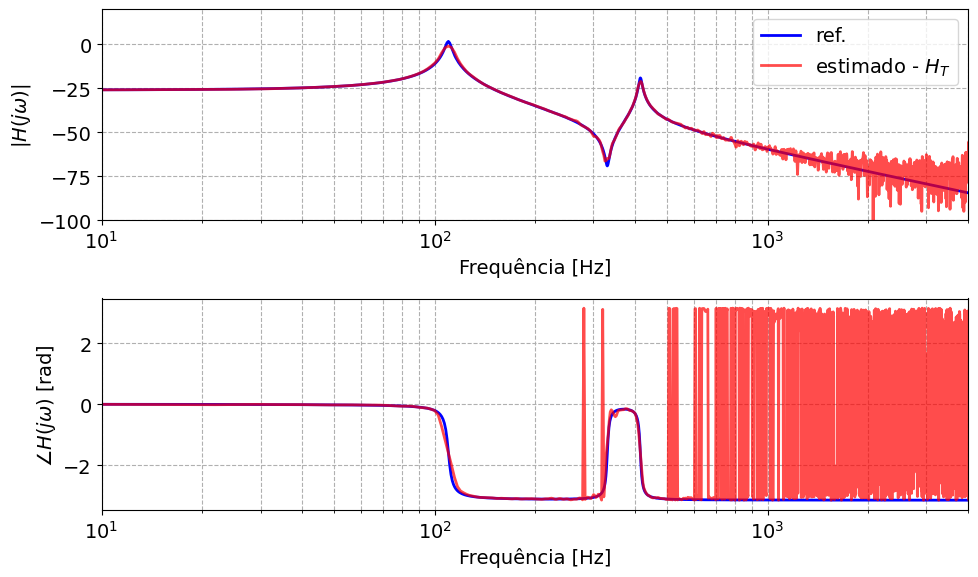

In [34]:
# Estimador HT
HT = (Syy - Sxx + np.sqrt((Sxx - Syy)**2 + 4*(np.abs(Sxy))**2))/(2 * Syx)

# Plot
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.semilogx(fh, 20*np.log10(np.abs(H)), linewidth = 2, color = 'b', label = 'ref.')
plt.semilogx(freq, 20*np.log10(np.abs(HT)), linewidth = 2, color = 'r', alpha=0.7, label =  r'estimado - $H_T$')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$|H(j \omega)|$')
plt.xlim((10, 0.8*fs/2))
plt.ylim((-100, 20))
plt.xlabel('Frequência [Hz]')

plt.subplot(2,1,2)
plt.semilogx(fh, np.angle(H), linewidth = 2, color = 'b')
plt.semilogx(freq, np.angle(HT), linewidth = 2, color = 'r', alpha=0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$\angle H(j \omega)$ [rad]')
plt.xlim((10, 0.8*fs/2))
#plt.ylim((-4, 4))
plt.xlabel('Frequência [Hz]')
plt.tight_layout()